# 基于神经网络的时间序列预测

本代码来自弗朗西斯卡所著《时间序列预测：基于机器学习和python实现》

In [1]:
import datetime as dt
import os
import warnings
from collections import UserDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)

## 将深度学习用作时间序列预测的原因

深度学习神经网络具有三个主要的内在特征：
- 深度学习神经网络能够自动从原始数据中学习和提取特征。
- 深度学习支持多个输入和输出。
- 循环神经网络擅长提取跨越相对较长序列的输入数据中的模式。

神经网络消除了对特征工程过程、数据缩放过程的大量迫切需求以及通过差分是数据保持稳定。

1、单变量时间序列是具有单个时间相关变量的序列。在单变量时间序列场景中，数据集将基于两个变量，即时间和历史观测值。  
2、多变量时间序列是具有多个与时间有关的变量。这样的序列属于多元时间序列。

将深度学习用于多步预测的主要方法有两种：
- 直接：开发单独的模型来预测每个的前置时间。
- 递归：开发一个模型来进行单步预测，并循环使用该模型，其中先前的预测用作输入以预测后续的前置时间。

## 基于循环神经网络的时间序列预测

### 循环神经网络

RNN是具有隐含状态和循环的神经网络，可以使信息随时间持续存在。

![hello](../images/p14.jpg)

RNN具有一个内部隐含状态，表示为$H$，可以将其反馈给网络。在此图中，RNN处理输入值$X$并产生输出值$Y$。隐含状态（表示为$H$）允许信息从网络的一个节点转发到下一个节点（按序列或向量组织）。向量现在具有与当前输入和先前输入有关的信息，通过$tanh$激活，输出为新的隐含状态。$tanh$激活用于调节通过网络的值，并且始终将值保持在-1和1之间。

$W$表示每个单元具有三组权重，一组用于输入（$X$），一组用于上一个时间步（$H$），剩余一组用于当前时间步的输出（$Y$）。这些权重值由训练过程确定，可以通过梯度下降来实现。

我们将相同的权重应用于输入序列中的不同项目，这意味着在输入时共享参数。如果不能在输入时共享参数，那么RNN就像普通的神经网络一样，每个输入节点都需要自己的权重。相反，RNN可以利用其隐含状态属性，该属性将当前输入绑定到下一个输入，并将此输入连接合并为串行输入。

![hello](../images/p15.jpg)

RNN问题
- 如果输入序列足够长，则其无法将信息从较早的时间步传递到较晚的时间步。
- 在反向传播期间，因为随着时间反向传播，其梯度会减小。因此循环神经网络会遇到梯度消失的问题，提出LSTM，在LSTM中引入了成为门和单元状态的其他元素。

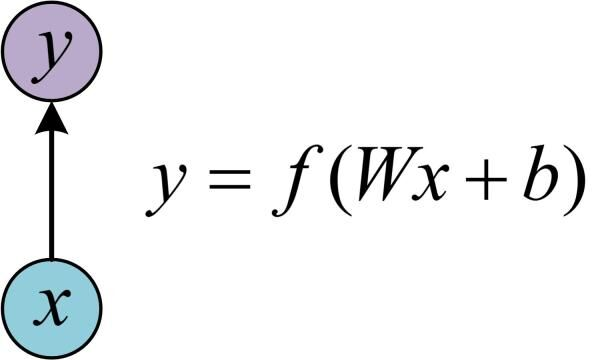
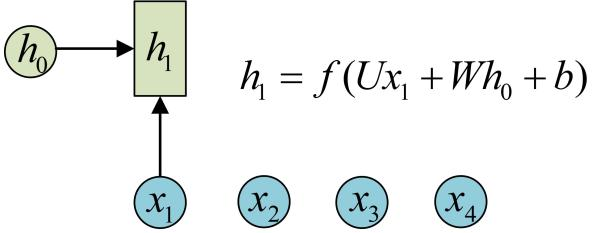
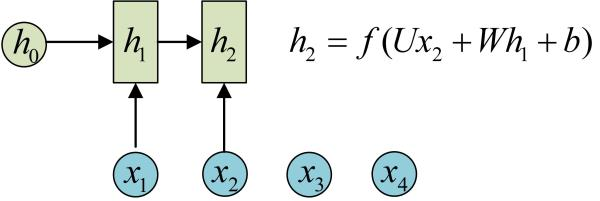
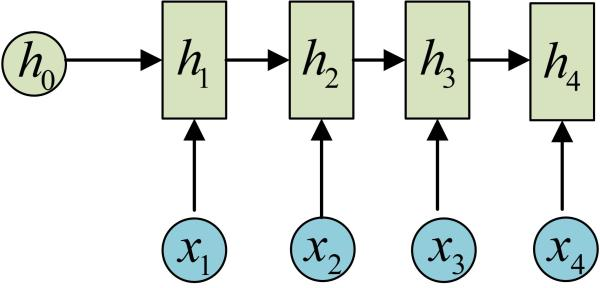
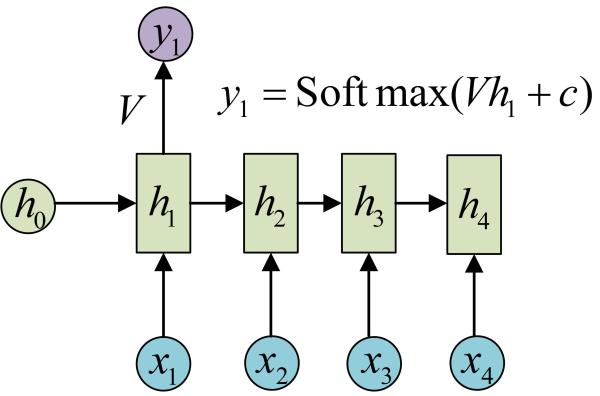
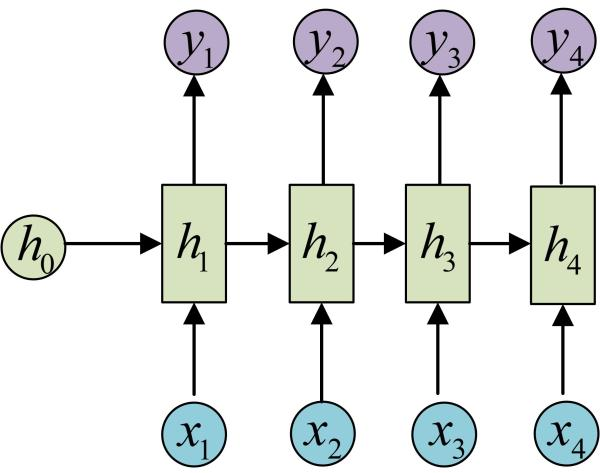

最经典的RNN结构，是$x1, x2, .....xn$，输出为$y1, y2, ...yn$，也就是说，输入和输出序列必须要是等长的。

### 长短期记忆

LSTM具有称为门和单元状态的内部机制，可以控制信息流。单元决定信息的选择、信息量以及存储和释放的时机：通过预测、反向传播误差和梯度下降调整权重的迭代过程来学习何时允许信息进入、离开和删除。

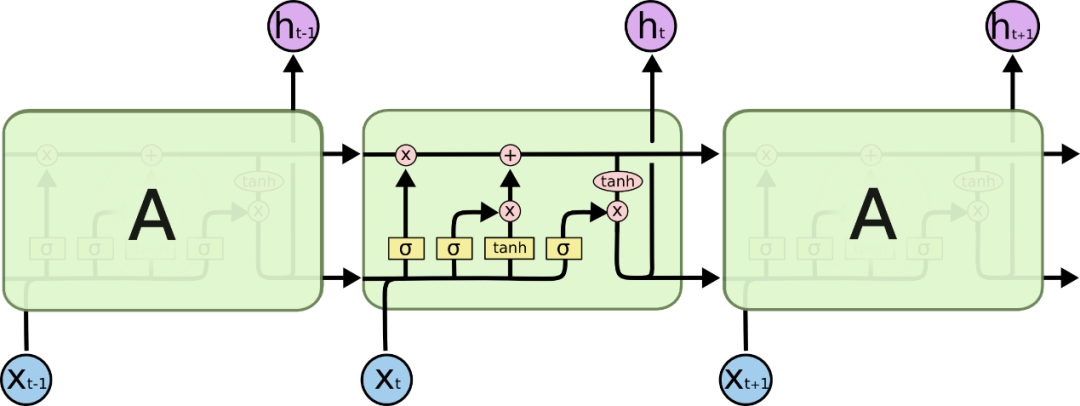

根据图示我们可以看到：LSTM主要有三个门组成，即遗忘门、输入门和输出门。

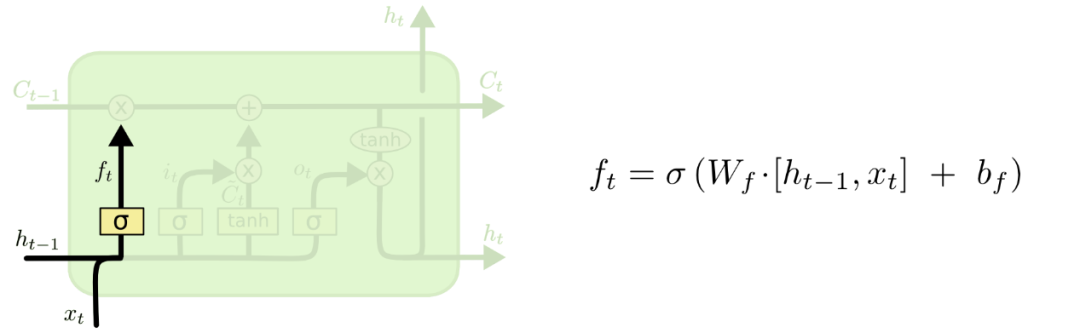

LSTM遗忘门会读取$h_{t-1}$和$x_t$，输出一个在0到1之间的数值，并传递给每个细胞状态$C_{t-1}$。1表示“完全保留”，0表示“完全舍弃”。

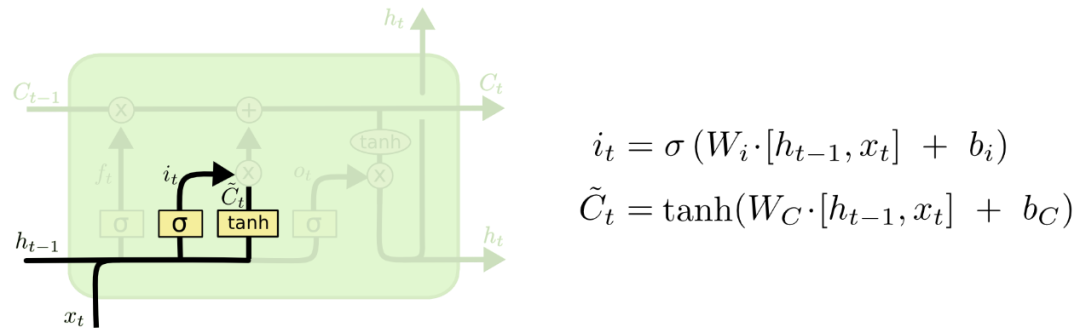

接下来，则由LSTM输入门确定什么样的新信息可以被存放在细胞状态中，这里包含两个部分：首先，sigmoid层决定什么值将要被更新；然后，tanh层创建一个新的候选值向量$\tilde{C_t}$，并在之后将$\tilde{C_t}$加入至状态中。

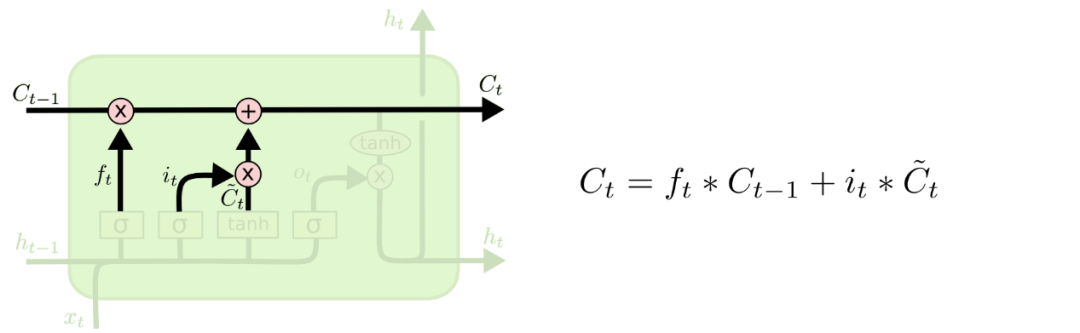

我们将旧状态与$f_t$相乘，丢弃掉确定需要丢弃的信息，并加上$i_t*\tilde{C_t}$，由此得到新的候选值。

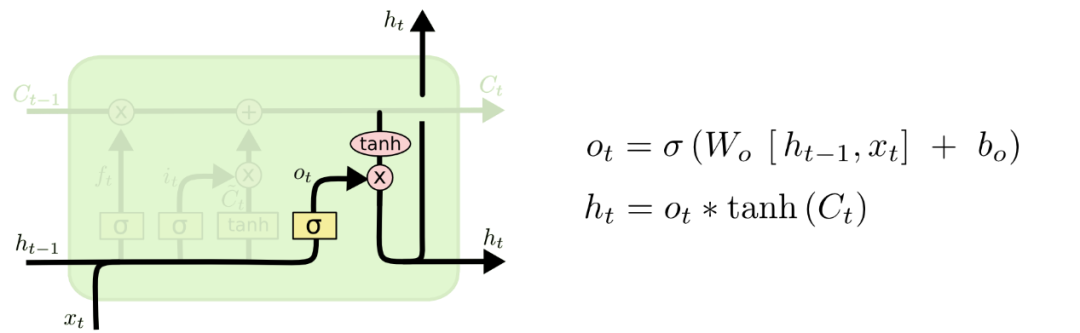

LSTM输出门将基于细胞状态形成一个过滤后的版本。首先，运行sigmoid层来确定细胞状态将要输出哪个部分；接着，通过tanh层处理细胞状态（得到一个在-1到1之间的值）并将它和sigmoid门的输出相乘，最终，LSTM输出门仅会输出我们确定需要的部分。

### 门控循环单元

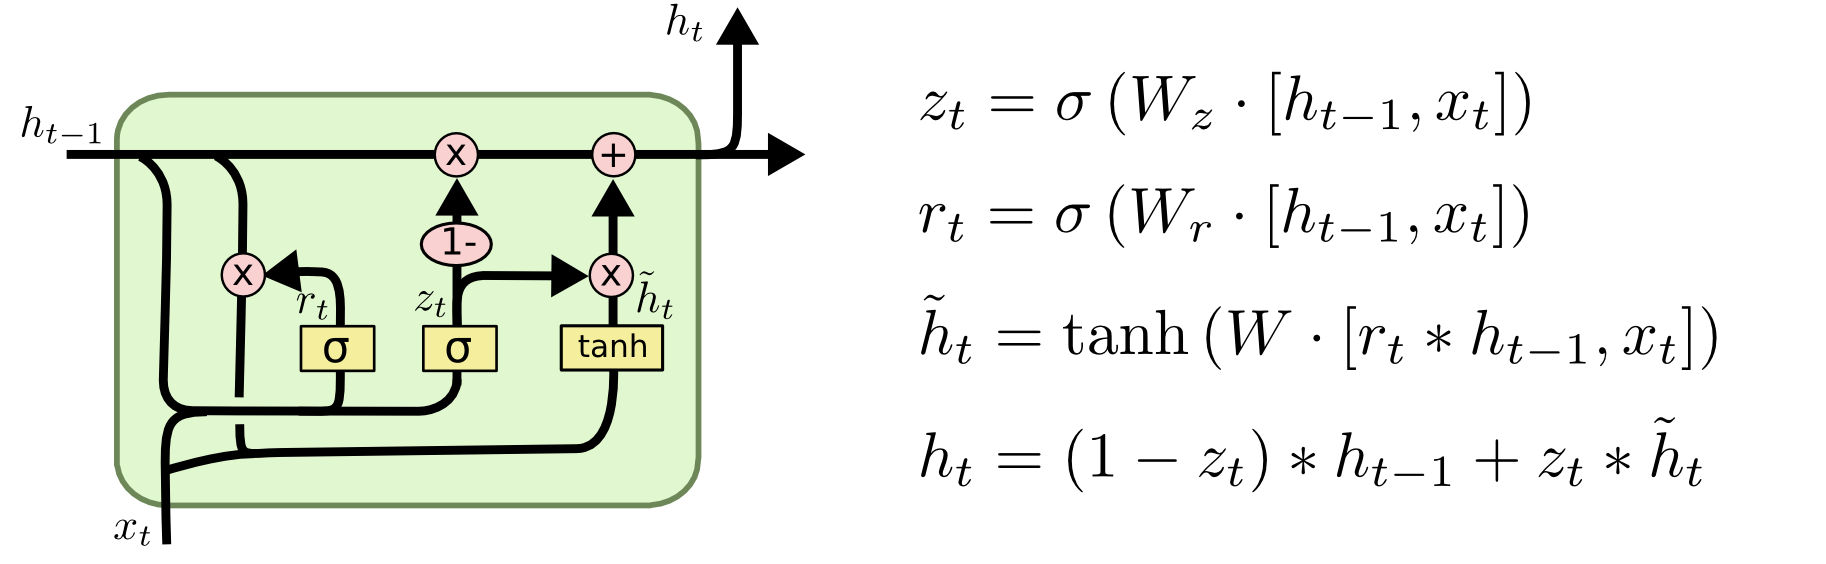

GRU将遗忘门和输入门合成了一个单一的更新门$z_t$。同样还混合了细胞状态和隐藏状态，和其他一些改动。最终的模型比标准的LSTM模型要简单，也是非常流行的变体。
- 更新门$z_t$：$z_{t}$是属于要记住的，反过来$1- z_{t}$则是属于忘记的，相当于对输入$h_{t-1}$、$x_{t}$做了一些更改/变化。
- 重置门$r_t$：相当于先见之明的把输入$h_{t-1}$、$x_{t}$在$z_{t}$/$1- z_{t}$对其做更改/变化之前，先事先存一份原始的。

## 准备时间序列数据

![hello](../images/p18.jpg)

样本数量、时间步和特征代表进行预测所需的条件（$X$），而样本和范围代表进行的预测（$Y$）。如果以单变量时间序列问题为例，而我们对单步预测（例如，下一个小时）感兴趣，那么前一个时间步的观测值（例如，前四个小时的值，即滞后观测值）被用作输入，输出是下一个时间步的观测值。

重要步骤：
- 在训练集上训练模型。
- 然后，在每个训练时期之后，将验证集用于评估模型，并确保模型不会过度拟合训练模型。
- 模型完成训练后，在测试集中评估模型。
- 在处理时间序列数据时，重要的是要确保验证集和测试集都覆盖了来自训练集的之后时间段，以使模型不会从将来的时间戳信息中受益。

### 数据可视化

In [2]:
ts_data = pd.read_csv("../data/energy.csv")
ts_data = pd.DataFrame(ts_data[["load", "temp"]].values, index=pd.to_datetime(ts_data["Unnamed: 0"].values), columns=["load", "temp"])
ts_data = ts_data.asfreq(freq='H') #转换为小时频率的数据
ts_data.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


对于能源预测案例，我们将2014年11月1日至2014年12月31日期间的数据划分为测试集。2014年9月1日至10月31日期间的数据划分为验证集，其他时间作为训练集。

In [3]:
valid_st_data_load = "2014-09-01 00:00:00"
test_st_data_load = "2014-11-01 00:00:00"

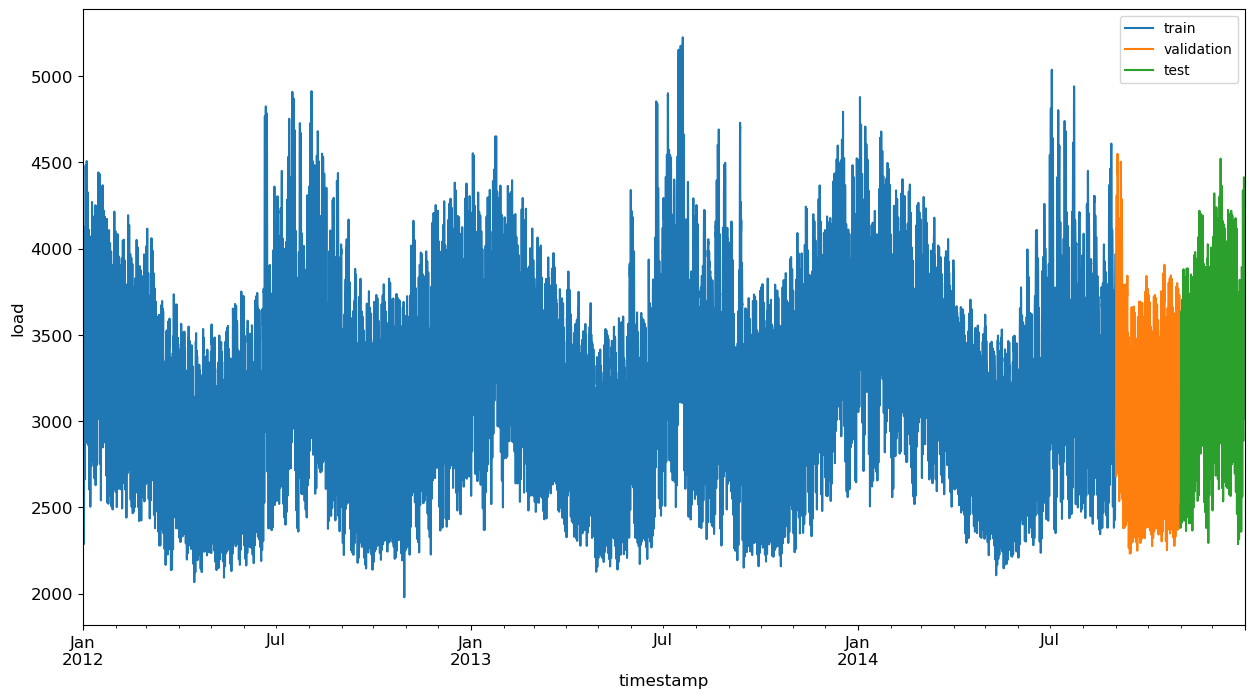

In [4]:
ts_data[ts_data.index < valid_st_data_load][["load"]].rename(columns={
    "load": "train"
}).join(
    ts_data[(ts_data.index >= valid_st_data_load)
            & (ts_data.index < test_st_data_load)][[
                "load"
            ]].rename(columns={"load": "validation"}),
    how="outer",
).join(ts_data[test_st_data_load:][["load"]].rename(columns={"load": "test"}),
       how="outer").plot(y=["train", "validation", "test"],
                         figsize=(15, 8),
                         fontsize=12)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("load", fontsize=12)
plt.show()

### 数据集准备

我们将$T$（滞后变量的数量）设置为6。这意味着每个样本的输入都是前6个小时负荷值的向量。$T=6$的选择是任意的。我们还将范围设置为1，意味着只预测下一个小时（$t+1$）的输出。

#### 训练集

In [8]:
T = 6
HORIZON = 1
#训练集
train = ts_data.copy()[ts_data.index < valid_st_data_load][["load"]]
#归一化
scaler = MinMaxScaler()
train["load"] = scaler.fit_transform(train)
#时移创建滞后和前导数据
train_shifted = train.copy()
train_shifted["y_t+1"] = train_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    train_shifted[str(T - t)] = train_shifted["load"].shift(T - t, freq="H")
y_col = "y_t+1"
X_cols = ["load_t-5", "load_t-4", "load_t-3", "load_t-2", "load_t-1", "load_t"]
train_shifted.columns = ["load_original"] + [y_col] + X_cols

train_shifted = train_shifted.dropna(how="any")
train_shifted.head(5)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23
2012-01-01 08:00:00,0.29,0.35,0.13,0.13,0.15,0.18,0.23,0.29
2012-01-01 09:00:00,0.35,0.37,0.13,0.15,0.18,0.23,0.29,0.35


#### 验证集

In [9]:
T = 6
HORIZON = 1
#训练集
valid = ts_data.copy()[(ts_data.index >= valid_st_data_load) & (ts_data.index < test_st_data_load)][["load"]]
#归一化
scaler = MinMaxScaler()
valid["load"] = scaler.fit_transform(valid)
#时移创建滞后和前导数据
valid_shifted = valid.copy()
valid_shifted["y_t+1"] = valid_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    valid_shifted[str(T - t)] = valid_shifted["load"].shift(T - t, freq="H")
y_col = "y_t+1"
X_cols = ["load_t-5", "load_t-4", "load_t-3", "load_t-2", "load_t-1", "load_t"]
valid_shifted.columns = ["load_original"] + [y_col] + X_cols

valid_shifted = valid_shifted.dropna(how="any")
valid_shifted.head(5)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2014-09-01 05:00:00,0.23,0.28,0.28,0.23,0.20,0.19,0.20,0.23
2014-09-01 06:00:00,0.28,0.36,0.23,0.20,0.19,0.20,0.23,0.28
2014-09-01 07:00:00,0.36,0.51,0.20,0.19,0.20,0.23,0.28,0.36
2014-09-01 08:00:00,0.51,0.64,0.19,0.20,0.23,0.28,0.36,0.51
2014-09-01 09:00:00,0.64,0.73,0.20,0.23,0.28,0.36,0.51,0.64


#### 测试集

In [10]:
T = 6
HORIZON = 1
#训练集
test = ts_data.copy()[test_st_data_load:][["load"]]
#归一化
scaler = MinMaxScaler()
test["load"] = scaler.fit_transform(test)
#时移创建滞后和前导数据
test_shifted = test.copy()
test_shifted["y_t+1"] = test_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    test_shifted[str(T - t)] = test_shifted["load"].shift(T - t, freq="H")
y_col = "y_t+1"
X_cols = ["load_t-5", "load_t-4", "load_t-3", "load_t-2", "load_t-1", "load_t"]
test_shifted.columns = ["load_original"] + [y_col] + X_cols

test_shifted = test_shifted.dropna(how="any")
test_shifted.head(5)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2014-11-01 05:00:00,0.10,0.19,0.10,0.07,0.05,0.04,0.06,0.10
2014-11-01 06:00:00,0.19,0.31,0.07,0.05,0.04,0.06,0.10,0.19
2014-11-01 07:00:00,0.31,0.40,0.05,0.04,0.06,0.10,0.19,0.31
2014-11-01 08:00:00,0.40,0.48,0.04,0.06,0.10,0.19,0.31,0.40
2014-11-01 09:00:00,0.48,0.51,0.06,0.10,0.19,0.31,0.40,0.48


![hello](../images/p19.jpg)

### 转换为张量

将$X$转换为（样本、时间步、特征）的形式，在此数据集中，我们有23370个样本，6个时间步和1个特征。

In [11]:
y_train = train_shifted[y_col].to_numpy()
X_train = train_shifted[X_cols].to_numpy()

In [12]:
y_valid = valid_shifted[y_col].to_numpy()
X_valid = valid_shifted[X_cols].to_numpy()

In [13]:
y_test = test_shifted[y_col].to_numpy()
X_test = test_shifted[X_cols].to_numpy()

将$X$输入重新构造为三维数组。

In [17]:
X_train = X_train.reshape(X_train.shape[0], T, 1)
X_train.shape

(23370, 6, 1)

In [18]:
X_valid = X_valid.reshape(X_valid.shape[0], T, 1)
X_valid.shape

(1458, 6, 1)

In [19]:
X_test = X_test.reshape(X_test.shape[0], T, 1)
X_test.shape

(1458, 6, 1)

## LSTM

- 单变量模型：单变量时间序列是指由按相等时间增量顺序记录的单个（标量）观测值组成的时间序列。
- 多变量模型：多变量时间序列具有多个时间相关变量，每个变量不仅取决于其过去的值，而且对其他变量也有一定的依赖性。

### tensorflow

#### 单变量单步预测模型

![hello](../images/p23.jpg)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Model, Sequential

In [21]:
LATENT_DIM = 5 #潜在维度，隐层个数
BATCH_SIZE = 32 #批尺寸，每个小批量的样本数量
EPOCHS = 10 #周期，训练算法循环遍历所有样本的最大次数

In [22]:
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 1)))
model.add(Dense(HORIZON))

In [23]:
model.compile(optimizer="RMSprop", loss="mse")

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 5)                 120       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________


提前停止是一种正则化方法，在使用迭代方法训练机器学习模型时可避免过拟合。

In [25]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

In [26]:
model_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_valid, y_valid),
    callbacks=[earlystop],
    verbose=1,
)

Epoch 1/10
731/731 [==============================] - 7s 6ms/step - loss: 0.0071 - val_loss: 0.0021
Epoch 2/10
731/731 [==============================] - 4s 5ms/step - loss: 9.1719e-04 - val_loss: 0.0013
Epoch 3/10
731/731 [==============================] - 4s 5ms/step - loss: 6.4150e-04 - val_loss: 0.0011
Epoch 4/10
731/731 [==============================] - 4s 5ms/step - loss: 5.7578e-04 - val_loss: 0.0011
Epoch 5/10
731/731 [==============================] - 4s 5ms/step - loss: 5.6536e-04 - val_loss: 0.0010
Epoch 6/10
731/731 [==============================] - 4s 5ms/step - loss: 5.5873e-04 - val_loss: 0.0010
Epoch 7/10
731/731 [==============================] - 4s 5ms/step - loss: 5.5922e-04 - val_loss: 9.8956e-04
Epoch 8/10
731/731 [==============================] - 4s 5ms/step - loss: 5.5510e-04 - val_loss: 0.0011
Epoch 9/10
731/731 [==============================] - 4s 5ms/step - loss: 5.5368e-04 - val_loss: 0.0011
Epoch 10/10
731/731 [==============================] - 4s 5ms/st

In [27]:
ts_predictions = model.predict(X_test)
ts_predictions

array([[0.18],
       [0.3 ],
       [0.42],
       ...,
       [0.66],
       [0.56],
       [0.5 ]], dtype=float32)

In [28]:
#反归一化
ev_ts_data = pd.DataFrame(
    ts_predictions, columns=["t+" + str(t) for t in range(1, HORIZON + 1)]
)
ev_ts_data["timestamp"] = test_shifted.index
ev_ts_data = pd.melt(ev_ts_data, id_vars="timestamp", value_name="prediction", var_name="h")
ev_ts_data["actual"] = np.transpose(y_test).ravel()
ev_ts_data[["prediction", "actual"]] = scaler.inverse_transform(
    ev_ts_data[["prediction", "actual"]]
)
ev_ts_data.head()

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,"2,695.49","2,714.00"
1,2014-11-01 06:00:00,t+1,"2,963.02","2,970.00"
2,2014-11-01 07:00:00,t+1,"3,223.14","3,189.00"
3,2014-11-01 08:00:00,t+1,"3,354.63","3,356.00"
4,2014-11-01 09:00:00,t+1,"3,487.49","3,436.00"


In [29]:
def mape(ts_predictions, actuals):
    """Mean absolute percentage error"""
    return ((ts_predictions - actuals).abs() / actuals).mean()

In [30]:
mape(ev_ts_data["prediction"], ev_ts_data["actual"])

0.0172295417810233

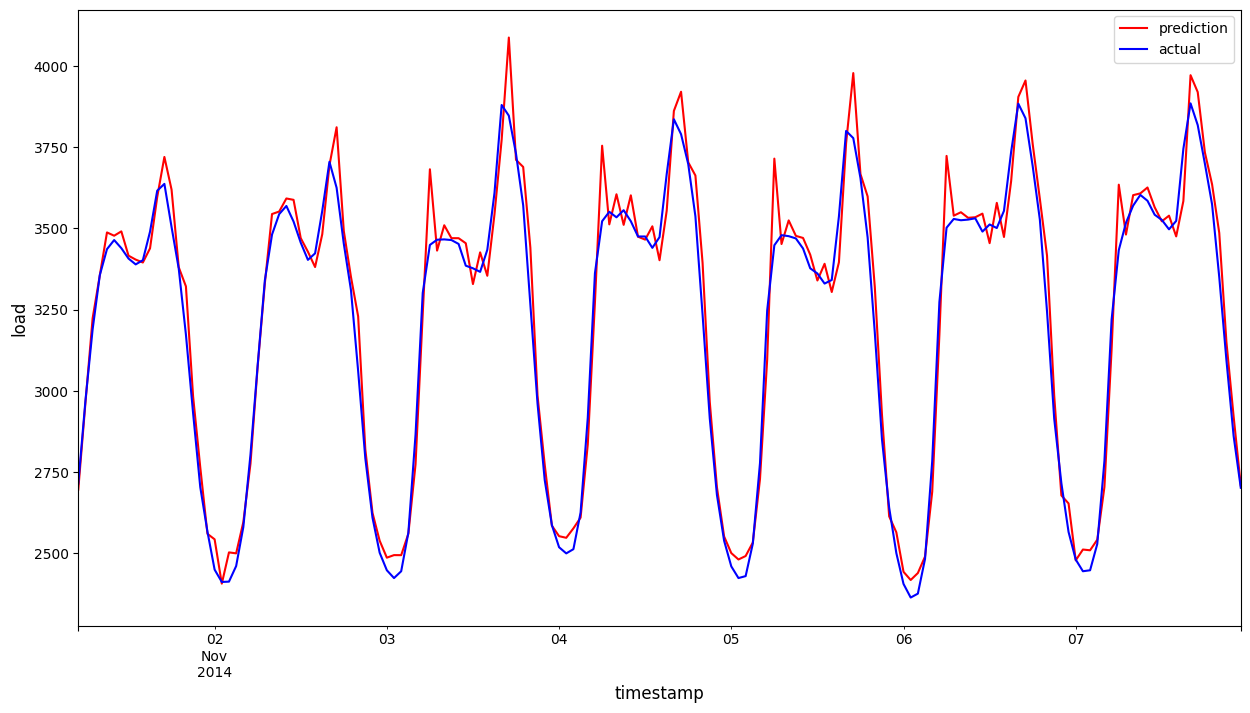

In [31]:
ev_ts_data[ev_ts_data.timestamp < "2014-11-08"].plot(
    x="timestamp", y=["prediction", "actual"], style=["r", "b"], figsize=(15, 8)
)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("load", fontsize=12)
plt.show()

#### 多变量单步预测模型

![hello](../images/p22.jpg)

In [33]:
valid_st_data_load = "2014-09-01 00:00:00"
test_st_data_load = "2014-11-01 00:00:00"

In [34]:
T = 6
HORIZON = 1

In [36]:
y_scaler = MinMaxScaler()
y_scaler.fit(train[["load"]])

MinMaxScaler()

In [42]:
train = ts_data.copy()[ts_data.index < valid_st_data_load][["load", "temp"]]
X_scaler = MinMaxScaler()
train[["load", "temp"]] = X_scaler.fit_transform(train)

#时移创建滞后和前导数据
train_shifted = train.copy()
train_shifted["y_t+1"] = train_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    train_shifted["load" + str(T - t)] = train_shifted["load"].shift(T - t, freq="H")
    train_shifted["temp" + str(T - t)] = train_shifted["temp"].shift(T - t, freq="H")
y_col = "y_t+1"
X_cols_load = ["load_t-5", "load_t-4", "load_t-3", "load_t-2", "load_t-1", "load_t"]
X_cols_temp = ["temp_t-5", "temp_t-4", "temp_t-3", "temp_t-2", "temp_t-1", "temp_t"]
train_shifted.columns = ["load_original"] + ["temp_original"] + [y_col] + X_cols_load + X_cols_temp

train_shifted = train_shifted.dropna(how="any")
train_shifted.head(5)

,load_original,temp_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t,temp_t-5,temp_t-4,temp_t-3,temp_t-2,temp_t-1,temp_t
2012-01-01 05:00:00,0.15,0.41,0.18,0.22,0.42,0.18,0.43,0.14,0.40,0.13,0.41,0.13,0.42,0.15,0.41
2012-01-01 06:00:00,0.18,0.40,0.23,0.18,0.43,0.14,0.40,0.13,0.41,0.13,0.42,0.15,0.41,0.18,0.40
2012-01-01 07:00:00,0.23,0.39,0.29,0.14,0.40,0.13,0.41,0.13,0.42,0.15,0.41,0.18,0.40,0.23,0.39
2012-01-01 08:00:00,0.29,0.39,0.35,0.13,0.41,0.13,0.42,0.15,0.41,0.18,0.40,0.23,0.39,0.29,0.39
2012-01-01 09:00:00,0.35,0.43,0.37,0.13,0.42,0.15,0.41,0.18,0.40,0.23,0.39,0.29,0.39,0.35,0.43


In [43]:
valid = ts_data.copy()[(ts_data.index >= valid_st_data_load) & (ts_data.index < test_st_data_load)][["load", "temp"]]
X_scaler = MinMaxScaler()
valid[["load", "temp"]] = X_scaler.fit_transform(valid)

#时移创建滞后和前导数据
valid_shifted = valid.copy()
valid_shifted["y_t+1"] = valid_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    valid_shifted["load" + str(T - t)] = valid_shifted["load"].shift(T - t, freq="H")
    valid_shifted["temp" + str(T - t)] = valid_shifted["temp"].shift(T - t, freq="H")
y_col = "y_t+1"
X_cols_load = ["load_t-5", "load_t-4", "load_t-3", "load_t-2", "load_t-1", "load_t"]
X_cols_temp = ["temp_t-5", "temp_t-4", "temp_t-3", "temp_t-2", "temp_t-1", "temp_t"]
valid_shifted.columns = ["load_original"] + ["temp_original"] + [y_col] + X_cols_load + X_cols_temp

valid_shifted = valid_shifted.dropna(how="any")
valid_shifted.head(5)

,load_original,temp_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t,temp_t-5,temp_t-4,temp_t-3,temp_t-2,temp_t-1,temp_t
2014-09-01 05:00:00,0.23,0.67,0.28,0.28,0.73,0.23,0.71,0.20,0.69,0.19,0.67,0.20,0.67,0.23,0.67
2014-09-01 06:00:00,0.28,0.66,0.36,0.23,0.71,0.20,0.69,0.19,0.67,0.20,0.67,0.23,0.67,0.28,0.66
2014-09-01 07:00:00,0.36,0.66,0.51,0.20,0.69,0.19,0.67,0.20,0.67,0.23,0.67,0.28,0.66,0.36,0.66
2014-09-01 08:00:00,0.51,0.69,0.64,0.19,0.67,0.20,0.67,0.23,0.67,0.28,0.66,0.36,0.66,0.51,0.69
2014-09-01 09:00:00,0.64,0.76,0.73,0.20,0.67,0.23,0.67,0.28,0.66,0.36,0.66,0.51,0.69,0.64,0.76


In [44]:
test = ts_data.copy()[test_st_data_load:][["load", "temp"]]
X_scaler = MinMaxScaler()
test[["load", "temp"]] = X_scaler.fit_transform(test)

#时移创建滞后和前导数据
test_shifted = test.copy()
test_shifted["y_t+1"] = test_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    test_shifted["load" + str(T - t)] = test_shifted["load"].shift(T - t, freq="H")
    test_shifted["temp" + str(T - t)] = test_shifted["temp"].shift(T - t, freq="H")
y_col = "y_t+1"
X_cols_load = ["load_t-5", "load_t-4", "load_t-3", "load_t-2", "load_t-1", "load_t"]
X_cols_temp = ["temp_t-5", "temp_t-4", "temp_t-3", "temp_t-2", "temp_t-1", "temp_t"]
test_shifted.columns = ["load_original"] + ["temp_original"] + [y_col] + X_cols_load + X_cols_temp

test_shifted = test_shifted.dropna(how="any")
test_shifted.head(5)

,load_original,temp_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t,temp_t-5,temp_t-4,temp_t-3,temp_t-2,temp_t-1,temp_t
2014-11-01 05:00:00,0.10,0.52,0.19,0.10,0.54,0.07,0.52,0.05,0.50,0.04,0.50,0.06,0.50,0.10,0.52
2014-11-01 06:00:00,0.19,0.52,0.31,0.07,0.52,0.05,0.50,0.04,0.50,0.06,0.50,0.10,0.52,0.19,0.52
2014-11-01 07:00:00,0.31,0.54,0.40,0.05,0.50,0.04,0.50,0.06,0.50,0.10,0.52,0.19,0.52,0.31,0.54
2014-11-01 08:00:00,0.40,0.55,0.48,0.04,0.50,0.06,0.50,0.10,0.52,0.19,0.52,0.31,0.54,0.40,0.55
2014-11-01 09:00:00,0.48,0.60,0.51,0.06,0.50,0.10,0.52,0.19,0.52,0.31,0.54,0.40,0.55,0.48,0.60


In [47]:
y_train = train_shifted[y_col].to_numpy()
X_train = train_shifted[X_cols_load+X_cols_temp].to_numpy()

In [48]:
y_valid = valid_shifted[y_col].to_numpy()
X_valid = valid_shifted[X_cols_load+X_cols_temp].to_numpy()

In [49]:
y_test = test_shifted[y_col].to_numpy()
X_test = test_shifted[X_cols_load+X_cols_temp].to_numpy()

In [50]:
X_train = X_train.reshape(X_train.shape[0], T, 2)
X_train.shape

(23370, 6, 2)

In [52]:
X_valid = X_valid.reshape(X_valid.shape[0], T, 2)
X_valid.shape

(1458, 6, 2)

In [54]:
X_test = X_test.reshape(X_test.shape[0], T, 2)
X_test.shape

(1458, 6, 2)

In [45]:
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = 50

model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 2)))
model.add(Dense(HORIZON))

In [46]:
model.compile(optimizer="RMSprop", loss="mse")

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 5)                 135       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


In [55]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

In [56]:
model_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_valid, y_valid),
    callbacks=[earlystop],
    verbose=1,
)

Epoch 1/50
731/731 [==============================] - 7s 7ms/step - loss: 0.0077 - val_loss: 0.0036
Epoch 2/50
731/731 [==============================] - 4s 6ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 3/50
731/731 [==============================] - 4s 5ms/step - loss: 7.4624e-04 - val_loss: 0.0013
Epoch 4/50
731/731 [==============================] - 3s 5ms/step - loss: 6.3155e-04 - val_loss: 0.0011
Epoch 5/50
731/731 [==============================] - 3s 5ms/step - loss: 5.9396e-04 - val_loss: 0.0010
Epoch 6/50
731/731 [==============================] - 4s 5ms/step - loss: 5.7245e-04 - val_loss: 0.0010
Epoch 7/50
731/731 [==============================] - 4s 5ms/step - loss: 5.5901e-04 - val_loss: 9.8911e-04
Epoch 8/50
731/731 [==============================] - 4s 5ms/step - loss: 5.4499e-04 - val_loss: 9.1877e-04
Epoch 9/50
731/731 [==============================] - 3s 5ms/step - loss: 5.3665e-04 - val_loss: 9.0747e-04
Epoch 10/50
731/731 [==============================] - 4s 5m

In [57]:
ts_predictions = model.predict(X_test)
ts_predictions

array([[0.2 ],
       [0.31],
       [0.42],
       ...,
       [0.62],
       [0.54],
       [0.47]], dtype=float32)

In [58]:
ev_ts_data = pd.DataFrame(
    ts_predictions, columns=["t+" + str(t) for t in range(1, HORIZON + 1)]
)
ev_ts_data["timestamp"] = test_shifted.index
ev_ts_data = pd.melt(ev_ts_data, id_vars="timestamp", value_name="prediction", var_name="h")
ev_ts_data["actual"] = np.transpose(y_test).ravel()
ev_ts_data[["prediction", "actual"]] = scaler.inverse_transform(
    ev_ts_data[["prediction", "actual"]]
)
ev_ts_data.head()

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,"2,727.34","2,714.00"
1,2014-11-01 06:00:00,t+1,"2,972.91","2,970.00"
2,2014-11-01 07:00:00,t+1,"3,218.25","3,189.00"
3,2014-11-01 08:00:00,t+1,"3,327.38","3,356.00"
4,2014-11-01 09:00:00,t+1,"3,477.49","3,436.00"


In [59]:
def mape(ts_predictions, actuals):
    """Mean absolute percentage error"""
    return ((ts_predictions - actuals).abs() / actuals).mean()

In [60]:
mape(ev_ts_data["prediction"], ev_ts_data["actual"])

0.015202632380089148

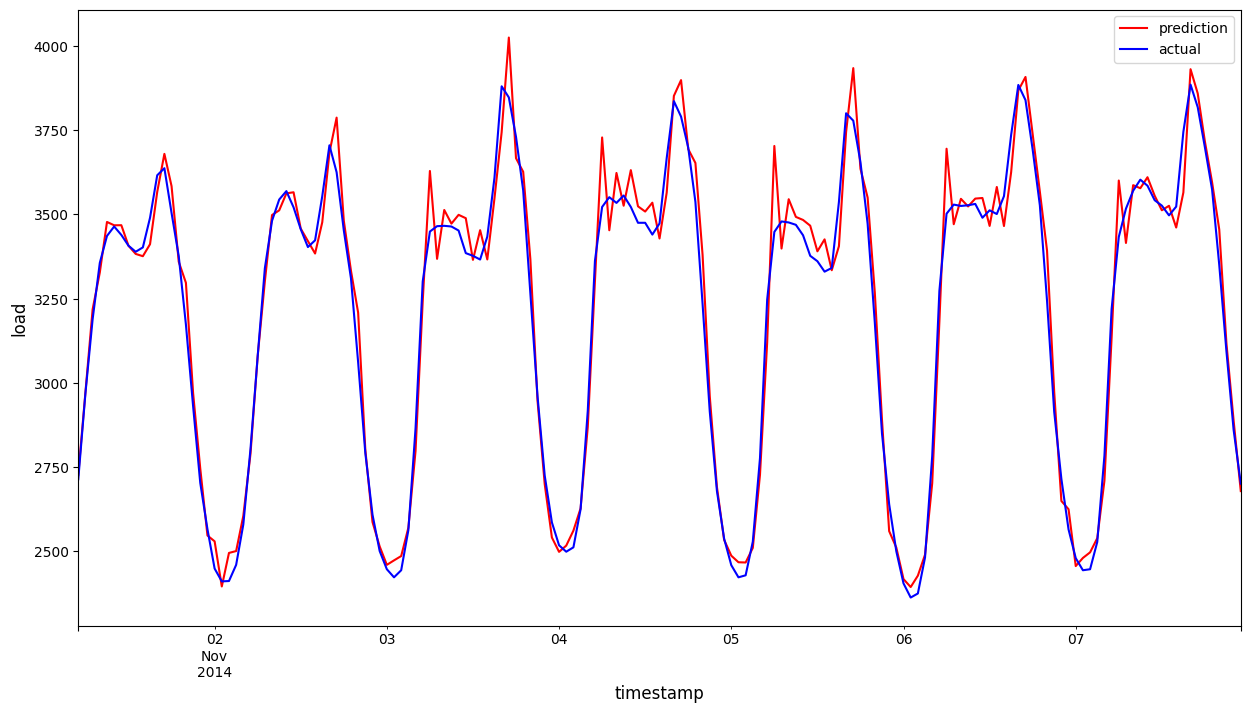

In [61]:
ev_ts_data[ev_ts_data.timestamp < "2014-11-08"].plot(
    x="timestamp", y=["prediction", "actual"], style=["r", "b"], figsize=(15, 8)
)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("load", fontsize=12)
plt.show()

### torch

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

#### 单变量单步预测模型

In [3]:
ts_data = pd.read_csv("../data/energy.csv")
ts_data = pd.DataFrame(ts_data[["load", "temp"]].values, index=pd.to_datetime(ts_data["Unnamed: 0"].values), columns=["load", "temp"])
ts_data = ts_data.asfreq(freq='H') #转换为小时频率的数据
ts_data.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [4]:
#数据集划分
def divide_dataset(df, valid_date, test_date, feature_list):
    #归一化
    scaler = MinMaxScaler()

    #训练集
    train = df.copy()[df.index < valid_date][feature_list]
    train[feature_list] = scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][feature_list]
    valid[feature_list] = scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][feature_list]
    test[feature_list] = scaler.fit_transform(test)
    test = test.values.astype('float32')
    return scaler, train, valid, test, train, valid, test

In [5]:
# 构造参数字典
params = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 1) y_train shape: (23376, 1)
x_valid shape: (1464, 1) y_valid shape: (1464, 1)
x_test shape: (1464, 1) y_test shape: (1464, 1)


In [6]:
#利用前lookback个数据，预测下delay个数据
def create_dataset(feature, target, lookback, delay):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    for i in range(lookback, len(feature) - delay):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    return torch.as_tensor(X), torch.as_tensor(y)

In [7]:
lookback = 6
delay = 1
X_train, y_train = create_dataset(x_train, y_train, lookback, delay)
X_valid, y_valid = create_dataset(x_valid, y_valid, lookback, delay)
X_test, y_test = create_dataset(x_test, y_test, lookback, delay)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

torch.Size([23369, 7, 1]) torch.Size([23369, 1, 1])
torch.Size([1457, 7, 1]) torch.Size([1457, 1, 1])
torch.Size([1457, 7, 1]) torch.Size([1457, 1, 1])


In [8]:
def train(X_train, X_valid, y_train, n_epochs, batch_size, shuffle=True, verbose = True):
    #LSTM
    class LSTM(nn.Module):
        def __init__(self):
            super().__init__()
            self.lstm = nn.LSTM(input_size=1, hidden_size=5, num_layers=1, batch_first=True)
            self.linear = nn.Linear(5, 1)
        def forward(self, x):
            x, _ = self.lstm(x)
            x = self.linear(x)
            return x
        
    #训练模型
    model = LSTM()
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()
    loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=shuffle, batch_size=batch_size)

    n_epochs = n_epochs
    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            #取最后一个作为预测结果
            y_pred = model(X_batch)[:,-1:,:]
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Validation
        if epoch % 10 != 0:
            continue
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            y_pred = model(X_train)[:,-1:,:]
            train_rmse = np.sqrt(loss_fn(y_pred, y_train))
            y_pred = model(X_valid)[:,-1:,:]
            valid_rmse = np.sqrt(loss_fn(y_pred, y_valid))
        if verbose == True:
            print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, valid_rmse))
    return model

In [9]:
model = train(X_train, X_valid, y_train, 20, 32, shuffle=True, verbose=False)

In [10]:
def predict(model, X_train, X_valid, X_test, y_true, lookback, delay, scaler):
    #数据集长度
    train_size = len(X_train) + lookback + delay
    valid_size = len(X_valid) + lookback + delay
    test_size = len(X_test) + lookback + delay
    
    #时间序列形状
    timeseries_y = y_true.values
    timeseries_x = y_true.index
    
    #关闭自动求导功能
    with torch.no_grad():
        '''测试集设置'''
        y_pred = model(X_train)
        y_pred = y_pred[:, -1, -1:] #取最后一个输出
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        train_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        train_plot_x = timeseries_x[: train_size]
        '''验证集设置'''
        y_pred = model(X_valid)
        y_pred = y_pred[:, -1, -1:]
        y_pred = scaler.inverse_transform(y_pred)
        valid_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        '''测试集设置'''
        y_pred = model(X_test)
        y_pred = y_pred[:, -1, -1:]
        y_pred = scaler.inverse_transform(y_pred)
        test_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, )) + [np.nan]*(delay-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

In [11]:
y_true = ts_data[['load']]
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    model, X_train, X_valid, X_test, y_true, lookback, delay, scaler)

In [12]:
def plot_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
    #绘图，原始图，训练图，验证图，测试图
    fig = plt.figure(1, (10, 5))
    ax = fig.add_subplot(1,1,1)
    plt.style.use('seaborn-v0_8-paper') #绘制背景色
    plt.grid(axis = 'y',linewidth=0.35) #绘制网格
    plt.title('true-predict-curve ') #图标题
    plt.xticks(rotation = 45) #rotation文字旋转方向
    ax.plot(timeseries_x, timeseries_y, linestyle='-',color = '#11b3b6',label = 'true_curve')
    ax.plot(train_plot_x, train_plot_y, linestyle='--',label = 'train_predict_curve')
    ax.plot(valid_plot_x, valid_plot_y, linestyle='--',label = 'valid_predict_curve')
    ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'test_predict_curve')
    ax.legend(frameon=False) #绘制图例
    plt.xlabel('Time')
    plt.ylabel(y_true.columns.values[0])
    plt.show()

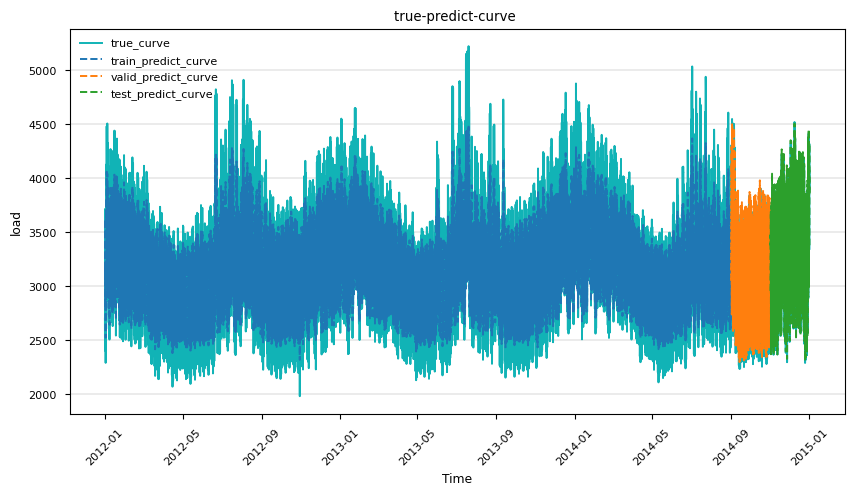

In [58]:
plot_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)

#### 单变量多步预测模型

In [14]:
ts_data = pd.read_csv("../data/energy.csv")
ts_data = pd.DataFrame(ts_data[["load", "temp"]].values, index=pd.to_datetime(ts_data["Unnamed: 0"].values), columns=["load", "temp"])
ts_data = ts_data.asfreq(freq='H') #转换为小时频率的数据
ts_data.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [15]:
#数据集划分
def divide_dataset(df, valid_date, test_date, feature_list):
    #归一化
    scaler = MinMaxScaler()

    #训练集
    train = df.copy()[df.index < valid_date][feature_list]
    train[feature_list] = scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][feature_list]
    valid[feature_list] = scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][feature_list]
    test[feature_list] = scaler.fit_transform(test)
    test = test.values.astype('float32')
    return scaler, train, valid, test, train, valid, test

In [16]:
# 构造参数字典
params = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 1) y_train shape: (23376, 1)
x_valid shape: (1464, 1) y_valid shape: (1464, 1)
x_test shape: (1464, 1) y_test shape: (1464, 1)


In [17]:
#利用前lookback个数据，预测下delay个数据
def create_dataset(feature, target, lookback, delay):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    for i in range(lookback, len(feature) - delay):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    return torch.as_tensor(X), torch.as_tensor(y)

In [18]:
lookback = 6
delay = 3
X_train, y_train = create_dataset(x_train, y_train, lookback, delay)
X_valid, y_valid = create_dataset(x_valid, y_valid, lookback, delay)
X_test, y_test = create_dataset(x_test, y_test, lookback, delay)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

torch.Size([23367, 7, 1]) torch.Size([23367, 3, 1])
torch.Size([1455, 7, 1]) torch.Size([1455, 3, 1])
torch.Size([1455, 7, 1]) torch.Size([1455, 3, 1])


In [19]:
def train(X_train, X_valid, y_train, n_epochs, batch_size, shuffle=True, verbose = True):
    #LSTM
    class LSTM(nn.Module):
        def __init__(self):
            super().__init__()
            self.lstm = nn.LSTM(input_size=1, hidden_size=5, num_layers=1, batch_first=True)
            self.linear = nn.Linear(5, 3) #delay=3
        def forward(self, x):
            x, _ = self.lstm(x)
            x = self.linear(x)
            return x
        
    #训练模型
    model = LSTM()
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()
    loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=shuffle, batch_size=batch_size)

    n_epochs = n_epochs
    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            #取最后一个作为预测结果
            y_pred = model(X_batch)[:,-1:,:]
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Validation
        if epoch % 10 != 0:
            continue
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            y_pred = model(X_train)[:,-1:,:]
            train_rmse = np.sqrt(loss_fn(y_pred, y_train))
            y_pred = model(X_valid)[:,-1:,:]
            valid_rmse = np.sqrt(loss_fn(y_pred, y_valid))
        if verbose == True:
            print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, valid_rmse))
    return model

In [20]:
model = train(X_train, X_valid, y_train, 20, 32, shuffle=True, verbose=False)

In [21]:
def predict(model, X_train, X_valid, X_test, y_true, lookback, delay, scaler):
    #数据集长度
    train_size = len(X_train) + lookback + delay
    valid_size = len(X_valid) + lookback + delay
    test_size = len(X_test) + lookback + delay
    
    #时间序列形状
    timeseries_y = y_true.values
    timeseries_x = y_true.index
    
    #关闭自动求导功能
    with torch.no_grad():
        '''测试集设置'''
        y_pred = model(X_train)
        y_pred = y_pred[:, -1, -1:] #取最后一个输出
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        train_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        train_plot_x = timeseries_x[: train_size]
        '''验证集设置'''
        y_pred = model(X_valid)
        y_pred = y_pred[:, -1, -1:]
        y_pred = scaler.inverse_transform(y_pred)
        valid_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        '''测试集设置'''
        y_pred = model(X_test)
        y_pred = y_pred[:, -1, -1:]
        y_pred = scaler.inverse_transform(y_pred)
        test_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, )) + [np.nan]*(delay-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

In [22]:
y_true = ts_data[['load']]
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    model, X_train, X_valid, X_test, y_true, lookback, delay, scaler)

In [23]:
def plot_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
    #绘图，原始图，训练图，验证图，测试图
    fig = plt.figure(1, (10, 5))
    ax = fig.add_subplot(1,1,1)
    plt.style.use('seaborn-v0_8-paper') #绘制背景色
    plt.grid(axis = 'y',linewidth=0.35) #绘制网格
    plt.title('true-predict-curve ') #图标题
    plt.xticks(rotation = 45) #rotation文字旋转方向
    ax.plot(timeseries_x, timeseries_y, linestyle='-',color = '#11b3b6',label = 'true_curve')
    ax.plot(train_plot_x, train_plot_y, linestyle='--',label = 'train_predict_curve')
    ax.plot(valid_plot_x, valid_plot_y, linestyle='--',label = 'valid_predict_curve')
    ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'test_predict_curve')
    ax.legend(frameon=False) #绘制图例
    plt.xlabel('Time')
    plt.ylabel(y_true.columns.values[0])
    plt.show()

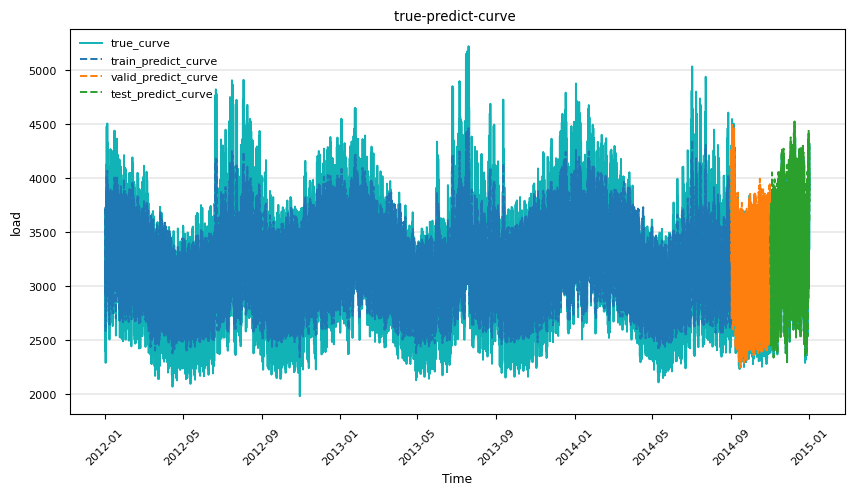

In [24]:
plot_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)

#### 多变量单步预测模型

In [25]:
ts_data = pd.read_csv("../data/energy.csv")
ts_data = pd.DataFrame(ts_data[["load", "temp"]].values, index=pd.to_datetime(ts_data["Unnamed: 0"].values), columns=["load", "temp"])
ts_data = ts_data.asfreq(freq='H') #转换为小时频率的数据
ts_data.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [26]:
#数据集划分
def divide_dataset(df, valid_date, test_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [27]:
# 构造参数字典
params = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", "temp"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 1)
x_valid shape: (1464, 2) y_valid shape: (1464, 1)
x_test shape: (1464, 2) y_test shape: (1464, 1)


In [28]:
#利用前lookback个数据，预测下delay个数据
def create_dataset(feature, target, lookback, delay):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    for i in range(lookback, len(feature) - delay):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    return torch.as_tensor(X), torch.as_tensor(y)

In [29]:
lookback = 6
delay = 1
X_train, y_train = create_dataset(x_train, y_train, lookback, delay)
X_valid, y_valid = create_dataset(x_valid, y_valid, lookback, delay)
X_test, y_test = create_dataset(x_test, y_test, lookback, delay)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

torch.Size([23369, 7, 2]) torch.Size([23369, 1, 1])
torch.Size([1457, 7, 2]) torch.Size([1457, 1, 1])
torch.Size([1457, 7, 2]) torch.Size([1457, 1, 1])


In [30]:
def train(X_train, X_valid, y_train, n_epochs, batch_size, shuffle=True, verbose = True):
    #LSTM
    class LSTM(nn.Module):
        def __init__(self):
            super().__init__()
            self.lstm = nn.LSTM(input_size=2, hidden_size=5, num_layers=1, batch_first=True)
            self.linear = nn.Linear(5, 1) #delay=1
        def forward(self, x):
            x, _ = self.lstm(x)
            x = self.linear(x)
            return x
        
    #训练模型
    model = LSTM()
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()
    loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=shuffle, batch_size=batch_size)

    n_epochs = n_epochs
    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            #取最后一个作为预测结果
            y_pred = model(X_batch)[:,-1:,:]
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Validation
        if epoch % 10 != 0:
            continue
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            y_pred = model(X_train)[:,-1:,:]
            train_rmse = np.sqrt(loss_fn(y_pred, y_train))
            y_pred = model(X_valid)[:,-1:,:]
            valid_rmse = np.sqrt(loss_fn(y_pred, y_valid))
        if verbose == True:
            print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, valid_rmse))
    return model

In [31]:
model = train(X_train, X_valid, y_train, 20, 32, shuffle=True, verbose=False)

In [32]:
def predict(model, X_train, X_valid, X_test, y_true, lookback, delay, scaler):
    #数据集长度
    train_size = len(X_train) + lookback + delay
    valid_size = len(X_valid) + lookback + delay
    test_size = len(X_test) + lookback + delay
    
    #时间序列形状
    timeseries_y = y_true.values
    timeseries_x = y_true.index
    
    #关闭自动求导功能
    with torch.no_grad():
        '''测试集设置'''
        y_pred = model(X_train)
        y_pred = y_pred[:, -1, -1:] #取最后一个输出
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        train_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        train_plot_x = timeseries_x[: train_size]
        '''验证集设置'''
        y_pred = model(X_valid)
        y_pred = y_pred[:, -1, -1:]
        y_pred = scaler.inverse_transform(y_pred)
        valid_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        '''测试集设置'''
        y_pred = model(X_test)
        y_pred = y_pred[:, -1, -1:]
        y_pred = scaler.inverse_transform(y_pred)
        test_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, )) + [np.nan]*(delay-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

In [33]:
y_true = ts_data[['load']]
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    model, X_train, X_valid, X_test, y_true, lookback, delay, scaler)

In [34]:
def plot_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
    #绘图，原始图，训练图，验证图，测试图
    fig = plt.figure(1, (10, 5))
    ax = fig.add_subplot(1,1,1)
    plt.style.use('seaborn-v0_8-paper') #绘制背景色
    plt.grid(axis = 'y',linewidth=0.35) #绘制网格
    plt.title('true-predict-curve ') #图标题
    plt.xticks(rotation = 45) #rotation文字旋转方向
    ax.plot(timeseries_x, timeseries_y, linestyle='-',color = '#11b3b6',label = 'true_curve')
    ax.plot(train_plot_x, train_plot_y, linestyle='--',label = 'train_predict_curve')
    ax.plot(valid_plot_x, valid_plot_y, linestyle='--',label = 'valid_predict_curve')
    ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'test_predict_curve')
    ax.legend(frameon=False) #绘制图例
    plt.xlabel('Time')
    plt.ylabel(y_true.columns.values[0])
    plt.show()

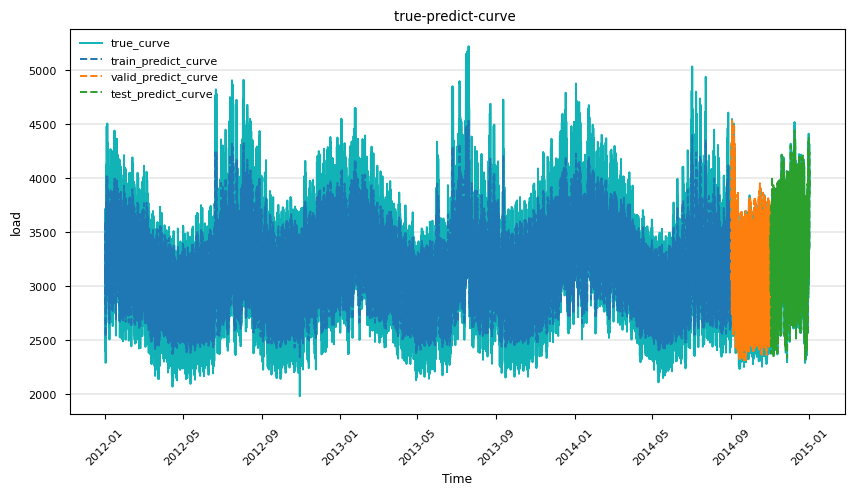

In [35]:
plot_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)

#### 多变量多步预测模型

In [36]:
ts_data = pd.read_csv("../data/energy.csv")
ts_data = pd.DataFrame(ts_data[["load", "temp"]].values, index=pd.to_datetime(ts_data["Unnamed: 0"].values), columns=["load", "temp"])
ts_data = ts_data.asfreq(freq='H') #转换为小时频率的数据
ts_data.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [37]:
#数据集划分
def divide_dataset(df, valid_date, test_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [38]:
# 构造参数字典
params = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", "temp"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 1)
x_valid shape: (1464, 2) y_valid shape: (1464, 1)
x_test shape: (1464, 2) y_test shape: (1464, 1)


In [39]:
#利用前lookback个数据，预测下delay个数据
def create_dataset(feature, target, lookback, delay):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    for i in range(lookback, len(feature) - delay):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    return torch.as_tensor(X), torch.as_tensor(y)

In [40]:
lookback = 6
delay = 3
X_train, y_train = create_dataset(x_train, y_train, lookback, delay)
X_valid, y_valid = create_dataset(x_valid, y_valid, lookback, delay)
X_test, y_test = create_dataset(x_test, y_test, lookback, delay)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

torch.Size([23367, 7, 2]) torch.Size([23367, 3, 1])
torch.Size([1455, 7, 2]) torch.Size([1455, 3, 1])
torch.Size([1455, 7, 2]) torch.Size([1455, 3, 1])


In [41]:
def train(X_train, X_valid, y_train, n_epochs, batch_size, shuffle=True, verbose = True):
    #LSTM
    class LSTM(nn.Module):
        def __init__(self):
            super().__init__()
            self.lstm = nn.LSTM(input_size=2, hidden_size=5, num_layers=1, batch_first=True)
            self.linear = nn.Linear(5, 3) #delay=3
        def forward(self, x):
            x, _ = self.lstm(x)
            x = self.linear(x)
            return x
        
    #训练模型
    model = LSTM()
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()
    loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=shuffle, batch_size=batch_size)

    n_epochs = n_epochs
    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            #取最后一个作为预测结果
            y_pred = model(X_batch)[:,-1:,:]
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Validation
        if epoch % 10 != 0:
            continue
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            y_pred = model(X_train)[:,-1:,:]
            train_rmse = np.sqrt(loss_fn(y_pred, y_train))
            y_pred = model(X_valid)[:,-1:,:]
            valid_rmse = np.sqrt(loss_fn(y_pred, y_valid))
        if verbose == True:
            print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, valid_rmse))
    return model

In [42]:
model = train(X_train, X_valid, y_train, 20, 32, shuffle=True, verbose=False)

In [43]:
def predict(model, X_train, X_valid, X_test, y_true, lookback, delay, scaler):
    #数据集长度
    train_size = len(X_train) + lookback + delay
    valid_size = len(X_valid) + lookback + delay
    test_size = len(X_test) + lookback + delay
    
    #时间序列形状
    timeseries_y = y_true.values
    timeseries_x = y_true.index
    
    #关闭自动求导功能
    with torch.no_grad():
        '''测试集设置'''
        y_pred = model(X_train)
        y_pred = y_pred[:, -1, -1:] #取最后一个输出
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        train_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        train_plot_x = timeseries_x[: train_size]
        '''验证集设置'''
        y_pred = model(X_valid)
        y_pred = y_pred[:, -1, -1:]
        y_pred = scaler.inverse_transform(y_pred)
        valid_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        '''测试集设置'''
        y_pred = model(X_test)
        y_pred = y_pred[:, -1, -1:]
        y_pred = scaler.inverse_transform(y_pred)
        test_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, )) + [np.nan]*(delay-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

In [44]:
y_true = ts_data[['load']]
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    model, X_train, X_valid, X_test, y_true, lookback, delay, scaler)

In [45]:
def plot_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
    #绘图，原始图，训练图，验证图，测试图
    fig = plt.figure(1, (10, 5))
    ax = fig.add_subplot(1,1,1)
    plt.style.use('seaborn-v0_8-paper') #绘制背景色
    plt.grid(axis = 'y',linewidth=0.35) #绘制网格
    plt.title('true-predict-curve ') #图标题
    plt.xticks(rotation = 45) #rotation文字旋转方向
    ax.plot(timeseries_x, timeseries_y, linestyle='-',color = '#11b3b6',label = 'true_curve')
    ax.plot(train_plot_x, train_plot_y, linestyle='--',label = 'train_predict_curve')
    ax.plot(valid_plot_x, valid_plot_y, linestyle='--',label = 'valid_predict_curve')
    ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'test_predict_curve')
    ax.legend(frameon=False) #绘制图例
    plt.xlabel('Time')
    plt.ylabel(y_true.columns.values[0])
    plt.show()

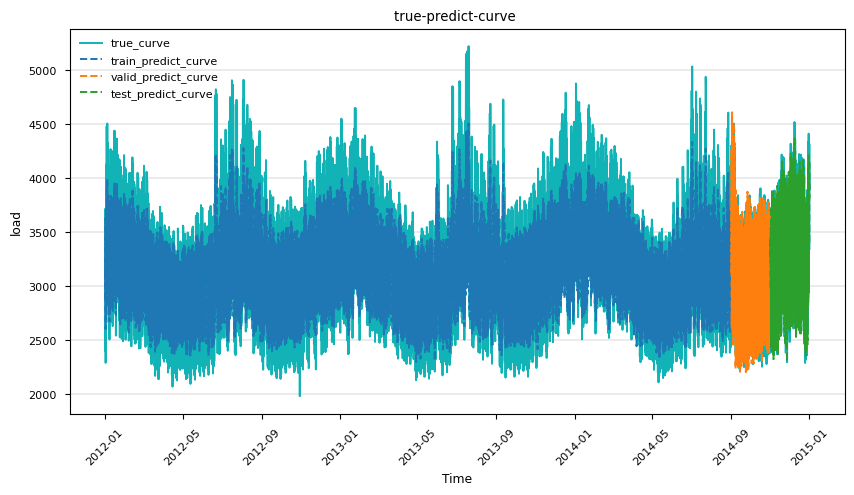

In [46]:
plot_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)

## GRU

### torch

#### 单变量单步预测模型

In [47]:
ts_data = pd.read_csv("../data/energy.csv")
ts_data = pd.DataFrame(ts_data[["load", "temp"]].values, index=pd.to_datetime(ts_data["Unnamed: 0"].values), columns=["load", "temp"])
ts_data = ts_data.asfreq(freq='H') #转换为小时频率的数据
ts_data.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [48]:
#利用前lookback个数据，预测下delay个数据
def create_dataset(feature, target, lookback, delay):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    for i in range(lookback, len(feature) - delay):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    return torch.as_tensor(X), torch.as_tensor(y)

In [49]:
#数据集划分
def divide_dataset(df, valid_date, test_date, feature_list):
    #归一化
    scaler = MinMaxScaler()

    #训练集
    train = df.copy()[df.index < valid_date][feature_list]
    train[feature_list] = scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][feature_list]
    valid[feature_list] = scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][feature_list]
    test[feature_list] = scaler.fit_transform(test)
    test = test.values.astype('float32')
    return scaler, train, valid, test, train, valid, test

In [50]:
# 构造参数字典
params = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 1) y_train shape: (23376, 1)
x_valid shape: (1464, 1) y_valid shape: (1464, 1)
x_test shape: (1464, 1) y_test shape: (1464, 1)


In [51]:
lookback = 6
delay = 1
X_train, y_train = create_dataset(x_train, y_train, lookback, delay)
X_valid, y_valid = create_dataset(x_valid, y_valid, lookback, delay)
X_test, y_test = create_dataset(x_test, y_test, lookback, delay)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

torch.Size([23369, 7, 1]) torch.Size([23369, 1, 1])
torch.Size([1457, 7, 1]) torch.Size([1457, 1, 1])
torch.Size([1457, 7, 1]) torch.Size([1457, 1, 1])


In [52]:
def train(X_train, X_valid, y_train, n_epochs, batch_size, shuffle=True, verbose = True):
    #GRU
    class GRU(nn.Module):
        def __init__(self):
            super().__init__()
            self.gru = nn.GRU(input_size=1, hidden_size=5, num_layers=1, batch_first=True)
            self.linear = nn.Linear(5, 1) #delay=1
        def forward(self, x):
            x, _ = self.gru(x)
            x = self.linear(x)
            return x
        
    #训练模型
    model = GRU()
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()
    loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=shuffle, batch_size=batch_size)

    n_epochs = n_epochs
    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            #取最后一个作为预测结果
            y_pred = model(X_batch)[:,-1:,:]
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Validation
        if epoch % 10 != 0:
            continue
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            y_pred = model(X_train)[:,-1:,:]
            train_rmse = np.sqrt(loss_fn(y_pred, y_train))
            y_pred = model(X_valid)[:,-1:,:]
            valid_rmse = np.sqrt(loss_fn(y_pred, y_valid))
        if verbose == True:
            print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, valid_rmse))
    return model

In [53]:
model = train(X_train, X_valid, y_train, 20, 32, shuffle=True, verbose=False)

In [54]:
def predict(model, X_train, X_valid, X_test, y_true, lookback, delay, scaler):
    #数据集长度
    train_size = len(X_train) + lookback + delay
    valid_size = len(X_valid) + lookback + delay
    test_size = len(X_test) + lookback + delay
    
    #时间序列形状
    timeseries_y = y_true.values
    timeseries_x = y_true.index
    
    #关闭自动求导功能
    with torch.no_grad():
        '''测试集设置'''
        y_pred = model(X_train)
        y_pred = y_pred[:, -1, -1:] #取最后一个输出
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        train_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        train_plot_x = timeseries_x[: train_size]
        '''验证集设置'''
        y_pred = model(X_valid)
        y_pred = y_pred[:, -1, -1:]
        y_pred = scaler.inverse_transform(y_pred)
        valid_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        '''测试集设置'''
        y_pred = model(X_test)
        y_pred = y_pred[:, -1, -1:]
        y_pred = scaler.inverse_transform(y_pred)
        test_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, )) + [np.nan]*(delay-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

In [55]:
y_true = ts_data[['load']]
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    model, X_train, X_valid, X_test, y_true, lookback, delay, scaler)

In [56]:
def plot_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
    #绘图，原始图，训练图，验证图，测试图
    fig = plt.figure(1, (10, 5))
    ax = fig.add_subplot(1,1,1)
    plt.style.use('seaborn-v0_8-paper') #绘制背景色
    plt.grid(axis = 'y',linewidth=0.35) #绘制网格
    plt.title('true-predict-curve ') #图标题
    plt.xticks(rotation = 45) #rotation文字旋转方向
    ax.plot(timeseries_x, timeseries_y, linestyle='-',color = '#11b3b6',label = 'true_curve')
    ax.plot(train_plot_x, train_plot_y, linestyle='--',label = 'train_predict_curve')
    ax.plot(valid_plot_x, valid_plot_y, linestyle='--',label = 'valid_predict_curve')
    ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'test_predict_curve')
    ax.legend(frameon=False) #绘制图例
    plt.xlabel('Time')
    plt.ylabel(y_true.columns.values[0])
    plt.show()

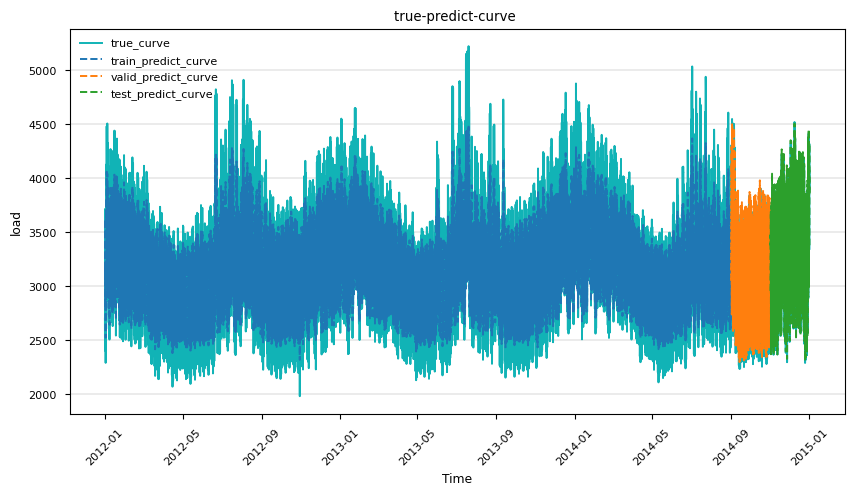

In [57]:
plot_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)

## Transformer

### torch

# 时间序列预测的模型部署

## 模型工作流

![hello](../images/p20.jpg)

## 数据流周期

![hello](../images/p21.jpg)

- 数百万已部署的数据仪表不断实时生成功耗数据。
- 收集数据并将其上传到云存储库。
- 在处理原始数据之前，先将其聚合到业务定义的变电站或区域级别。
- 进行特征工程，进而生成模型训练或评价所需的数据，特征集数据存储在数据库中。
- 调用再训练服务以继续训练预测模型，该模型的新版本将保存下来以便Web服务的评价可以再使用。
- 根据适应所需预测频率的计划评价Web服务。
- 预测的数据结果存储在最终用户可访问到的数据库中。
- 客户端检索预测并将其应用回网络中，根据所需用例再进行调用。